In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import nibabel as nib
import SimpleITK as sitk
import yaml
import torchio as tio
from dataset.hmri_dataset import HMRIDataModule

from models.pl_model import Model
import torch
from utils.utils import get_pretrained_model
this_path = Path().resolve()



# import torch
# import torchvision

this_path = Path().resolve()
# study_path = Path("/mrhome/kristiannm/tmp")
# "X95478_T2w.nii"

In [4]:
inf_pd_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/classification_results/3_val_inference_results.csv')
exps_results_pd_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/classification_results/3_val_exps_results.csv')
exp3_inf_df = pd.read_csv(inf_pd_path, index_col=0)
exp3_exp_df = pd.read_csv(exps_results_pd_path, index_col=0)


In [8]:
exp3_inf_df.loc[(exp3_inf_df.map_type == 'MTsat') & (exp3_inf_df.exp_type == '3B'), :]

,preds,logits,targets,sm_preds,split,exp_name,map_type,exp_type
subj_id,,,,,,,,
sub-021,[1],[[-4.2831745 -0.9077629]],[[0 1]],[[0.03307282 0.96692723]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B
sub-064,[0],[[-0.97698563 -4.2508793 ]],[[1 0]],[[0.96352226 0.03647773]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B
sub-042,[0],[[-1.1251254 -5.3120914]],[[0 1]],[[0.98503506 0.01496496]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B
sub-066,[1],[[-6.054292 -0.8371397]],[[0 1]],[[0.0053935 0.99460655]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B
sub-041,[1],[[-3.9995718 -2.338223 ]],[[0 1]],[[0.15958102 0.84041893]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B
sub-019,[1],[[-9.222531 2.6831806]],[[0 1]],[[6.7516817e-06 9.9999321e-01]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B
sub-036,[0],[[-1.730749 -4.0686154]],[[1 0]],[[0.9119649 0.08803507]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B
sub-039,[1],[[-4.08229 -1.3547521]],[[0 1]],[[0.06136782 0.93863213]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B
sub-035,[1],[[-10.469256 3.1422598]],[[0 1]],[[1.226290e-06 9.999988e-01]],val,3B_hMRI_MTsat_optim_adam_lr_0.001,MTsat,3B


In [17]:

root_dir = Path("/mrhome/alejandrocu/Documents/exploring")
md_df = pd.read_csv(root_dir/'PPMI_t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

In [8]:
md_df_first.Group.value_counts()

PD         372
Control    109
Name: Group, dtype: int64

In [2]:
with open('config/config.yaml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

augmentations = tio.Compose([                                        
                            tio.RandomAffine(scales=(0.15, 0.15, 0.15), 
                                            degrees=(15, 0, 15),
                                            # isotropic=True,
                                            # center='image',
                                            default_pad_value=0),
                            # # tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                            tio.RandomGamma(p=0.5),
                            # # tio.RandomNoise(p=0.5, mean=0.5, std=0.05), # p=0.5
                            # # tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                            # # tio.RandomBiasField(p=0.25),
                            ])

data = HMRIDataModule(md_df=md_df,
                        root_dir=root_dir,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()


------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016']


In [18]:
 # create model
pretrained_model = get_pretrained_model(chkpt_path=Path(cfg['model']['chkpt_path']),
                                input_channels=cfg['model']['in_channels'])
model = Model(net=pretrained_model.net, **cfg['model'])

# model.to('cpu')
# model.net


loading pretrained model pretrain/resnet_10_23dataset.pth
Pretrained 3D resnet has a single input channel


In [17]:
model = Model(net='3dresnet', **cfg['model'])
model.net.conv1.weight

loading pretrained model pretrain/resnet_10_23dataset.pth
Pretrained 3D resnet has a single input channel


Parameter containing:
tensor([[[[[ 7.0446e-04, -1.4719e-03,  1.6743e-03,  ..., -1.5514e-02,
             2.8309e-03, -2.6263e-02],
           [-2.0083e-03, -1.0002e-02, -1.0803e-02,  ...,  5.9019e-03,
             1.0087e-02,  2.9132e-03],
           [ 5.0011e-03,  1.3706e-02, -7.8183e-03,  ...,  7.6552e-03,
             1.2210e-03, -1.3733e-02],
           ...,
           [-1.0091e-02, -1.2707e-02, -9.1554e-03,  ..., -1.3698e-02,
             1.2041e-03,  7.8956e-03],
           [-3.2382e-03, -1.8490e-02, -1.2179e-03,  ..., -8.7413e-03,
            -1.1109e-02,  1.1153e-02],
           [-4.6899e-03,  3.2384e-03, -9.0199e-03,  ...,  1.0460e-02,
             6.7402e-03, -6.9497e-04]],

          [[ 1.6510e-02,  2.8952e-04, -7.2591e-04,  ..., -8.3258e-03,
            -5.3124e-03, -3.8287e-03],
           [ 1.6447e-02,  1.1109e-02, -3.9503e-03,  ...,  2.0765e-02,
             7.8404e-03,  6.3740e-03],
           [ 6.5738e-03, -8.8695e-03, -1.0393e-02,  ..., -3.8089e-04,
            -1.187

In [3]:
for batch in data.train_dataloader():
    inputs, targets = batch['image'][tio.DATA], batch['label']
    print(inputs.shape)
    break

torch.Size([3, 1, 100, 130, 100])


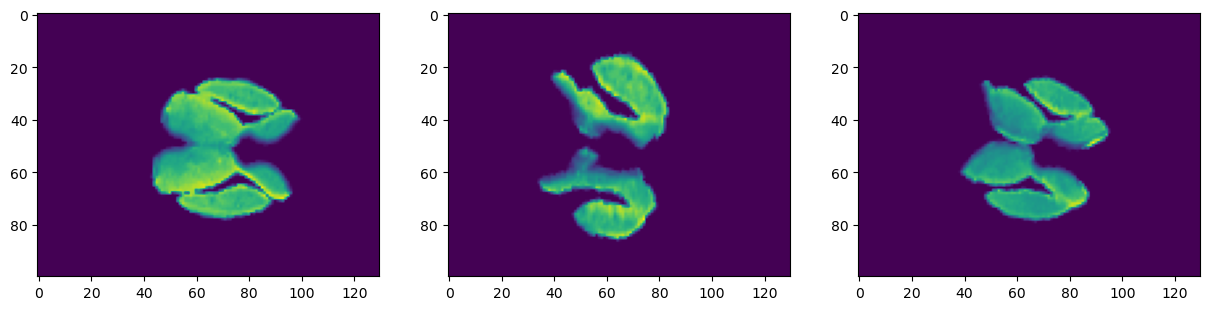

In [4]:
# print inputs
slice_idx = 80
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(inputs[0, 0, :, :, slice_idx])
ax[1].imshow(inputs[1, 0, :, :, slice_idx])
ax[2].imshow(inputs[2, 0, :, :, slice_idx])
plt.show()

In [11]:
# inputs = torch.randn(1, 1, 200, 200, 200)
outputs = model.net(inputs)

In [12]:
outputs.shape

torch.Size([3, 2])

### Creating MD

In [12]:
data_folder = Path('/mnt/projects/7TPD')
bids_folder = data_folder / 'bids'
bids_folder.exists()

True

In [13]:
metadata = []
for n, folder in enumerate(bids_folder.iterdir()):
    if folder.is_dir():
        px_data = {}
        if 'sub-' in folder.name:
            px_data['id'] = folder.name
            px_data['s01-7t'] = False
            px_data['s01-3t'] = False
            px_data['s02-7t'] = False
            px_data['s03-7t'] = False
            for session in folder.iterdir():    

                if '01achieva7t' in session.name:                    
                    px_data['s01-7t'] = True
                    px_data['s01-7t-anat'] = None
                    px_data['s01-7t-fmap'] = None
                    for dtype_folder in session.iterdir():
                        if 'anat' in dtype_folder.name:
                            sequences = [image.name.split('01achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-7t-anat'] = sequences
                        if 'fmap' in dtype_folder.name:
                            sequences = [image.name.split('01achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-7t-fmap'] = sequences

                elif '01prisma3t' in session.name:
                    px_data['s01-3t'] = True
                    px_data['s01-3t-anat'] = None
                    px_data['s01-3t-fmap'] = None
                    px_data['s01-3t-dwi'] = None
                    px_data['s01-3t-func'] = None
                    for dtype_folder in session.iterdir():
                        if 'anat' in dtype_folder.name:
                            sequences = [image.name.split('01prisma3t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-3t-anat'] = sequences
                        if 'fmap' in dtype_folder.name:
                            sequences = [image.name.split('01prisma3t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-3t-fmap'] = sequences
                        if 'dwi' in dtype_folder.name:
                            sequences = [image.name.split('01prisma3t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-3t-dwi'] = sequences
                        if 'func' in dtype_folder.name:
                            sequences = [image.name.split('01prisma3t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s01-3t-func'] = sequences

                elif '02achieva7t' in session.name:
                    px_data['s02-7t'] = True
                    px_data['s02-7t-anat'] = None
                    px_data['s02-7t-fmap'] = None
                    # px_data['s02-7t-dwi'] = None
                    px_data['s02-7t-func'] = None
                    for dtype_folder in session.iterdir():
                        if 'anat' in dtype_folder.name:
                            sequences = [image.name.split('02achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s02-7t-anat'] = sequences
                        if 'fmap' in dtype_folder.name:
                            sequences = [image.name.split('02achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s02-7t-fmap'] = sequences
                        # if 'dwi' in dtype_folder.name:
                        #     sequences = [image.name.split('02achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                        #     px_data['s02-7t-dwi'] = sequences
                        if 'func' in dtype_folder.name:
                            sequences = [image.name.split('02achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s02-7t-func'] = sequences

                elif '03achieva7t' in session.name:
                    px_data['s03-7t'] = True
                    px_data['s03-7t-anat'] = None
                    px_data['s03-7t-fmap'] = None
                    # px_data['s03-7t-dwi'] = None
                    px_data['s03-7t-func'] = None
                    for dtype_folder in session.iterdir():
                        if 'anat' in dtype_folder.name:
                            sequences = [image.name.split('03achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s03-7t-anat'] = sequences
                        if 'fmap' in dtype_folder.name:
                            sequences = [image.name.split('03achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s03-7t-fmap'] = sequences
                        # if 'dwi' in dtype_folder.name:
                        #     sequences = [image.name.split('03achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            # px_data['s03-7t-dwi'] = sequences
                        if 'func' in dtype_folder.name:
                            sequences = [image.name.split('03achieva7t')[-1] for image in dtype_folder.iterdir() if 'nii.gz' in image.name]
                            px_data['s03-7t-func'] = sequences        
            metadata.append(px_data)
            # if n > 3:
            #     break   
# pd.DataFrame(metadata)            

In [14]:
pd.DataFrame(metadata).fillna(0).to_csv(this_path/'metadata2.csv')

### Reading data files

In [32]:
# pd.DataFrame(metadata).fillna(0).to_csv(this_path/'metadata.csv')
# df = pd.DataFrame(metadata).fillna(0)

# reading original metadata
# bids_df = pd.read_csv(this_path/'metadata.csv', index_col=0)

# reading second run metadata
bids_df = pd.read_csv(this_path/'metadata2.csv', index_col=0)
subreg_df = pd.read_excel(this_path/"subject_registry_Birgitte_acu.xls")
subreg_df.drop(['Ini', 'name', 'tel', 'email', 'Audiometry'], axis=1, inplace=True)
log2bids_df = pd.read_excel(this_path/"logno2bids_acu.xls")

In [3]:
log2bids_df.rename(columns={'subject_id':'X-number'}, inplace=True)
log2bids_df = log2bids_df.loc[:, ['X-number', 'participant_id']]
x2bidsmap = {}
for i, data in log2bids_df.iterrows():
    if data['X-number'] in x2bidsmap.keys() and data['participant_id'] != x2bidsmap[data['X-number']]:
        print('duplicate', x2bidsmap[data['X-number']])
        print(data)
        # print(data)
    else:
        x2bidsmap[data['X-number']] = data['participant_id']


# res = log2bids_df[log2bids_df.duplicated(subset=['X-number', 'participant_id'], keep=False)]
# res.sort_values('X-number')

duplicate sub-098
X-number           X37397
participant_id    sub-123
Name: 294, dtype: object
duplicate sub-082
X-number           X11901
participant_id    sub-124
Name: 295, dtype: object


In [4]:
bids2xmap = {}
for i, data in log2bids_df.iterrows():
    if data['participant_id'] in bids2xmap.keys() and data['X-number'] != bids2xmap[data['participant_id']]:
        print('Duplicated bids', bids2xmap['participant_id'])
        print(data)
    else:
        bids2xmap[data['participant_id']] = data['X-number']

In [5]:
log2bids_df

,X-number,participant_id
0,X40270,sub-001
1,X94582,sub-002
2,X46603,sub-003
3,X83822,sub-004
4,X52338,sub-005
...,...,...
304,X27474,sub-125
305,X84202,sub-126
306,X15094,sub-127
307,X36063,sub-128


In [6]:
subreg_df

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status
0,PD01,1,0.0,78.0,X40270,19.09.2018,OK,Y,29.09.2018,K0556,NaN,NaN,y,"Y, but structural low qual",U/N,First MT-weighted image with folding-in of ear...,OK
1,HC01,0,1.0,76.0,X94582,19.09.2018,OK,Y,29.09.2018,K0557,NaN,NaN,y,"Y, but structural low qual. Maybe call",Y/Y,First MT-weighted image with folding-in of ear...,OK
2,PD02,1,0.0,72.0,X46603,24.09.2018,"BP, BIS-11, QUIP 18/11-18",Y,18.11.2018,K0621,L565,Y,y,N,Y/Y,C46603 on Achieva. Hypointensity in left cauda...,OK
3,PD03,1,0.0,60.0,X83822,12.10.2018,OK,Y,28.10.2018,K0589,L634,Y,y,"K0899,",Y/N,3T Prisma out of order. Participant agrees to ...,NO
4,PD04,1,0.0,38.0,X52338,12.10.2018,OK,Y,28.10.2018,K0590,K564,Y,y,"Audiometry: OK, apart from 6K right",Y/Y,3T Prisma out of order 28/10. Participant agre...,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,PD77,1,1.0,49.0,X90517,14.06.2022,OK,Y,01.07.2022,K1706,NaN,y,y,NaN,NaN,NaN,OK
123,PD78,1,0.0,57.0,X80973,27.05.2022,OK,N,NaN,NaN,NaN,NaN,NaN,Under udredning for atypisk PD,NaN,NaN,EXC
124,PD79,1,0.0,59.0,X85428,14.06.2022,OK,Y,07.07.2022,K1714,NaN,y,y,NaN,NaN,NaN,OK
125,PD80,1,0.0,81.0,X57407,15.08.2022,OK,Y,18.08.2022,K1743,NaN,y,n,Bad hearing,NaN,Shoulder pain during scan. Had to restart. Use...,OK


In [33]:
subreg_df['subject'] = [x2bidsmap[x] if x in x2bidsmap.keys() else 'None' for x in subreg_df['X-number'].values]

In [34]:
# patients with no BIDS number (ID) and D2Status as EXC (excluded) = 13
subreg_df.loc[subreg_df.subject == 'None', :]

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status,subject
8,PD08,1,1.0,70.0,X27455,02.11.2018,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Knækket metalbor I tand. Ikke sikkert skannerk...,EXC,None
11,PD11,1,NaN,NaN,X05588,20.11.2018,OK,NaN,16.12.2018,NaN,NaN,NaN,NaN,NaN,NaN,Not scanned on 16.12.2018 due to unreported ta...,EXC,None
27,HC05,0,NaN,NaN,X70177,15.05.2019,Subject excluded due to migraine.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
59,PD41,1,1.0,71.0,X13338,29.06.2020,Excluded due to history w SAH,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
61,HC21,0,1.0,40.0,X62925,04.08.2020,OK,Y,12.10.2020,NaN,NaN,NaN,NaN,NaN,NaN,Dropped out before D2,EXC,None
64,PD44,1,1.0,53.0,X40631,26.08.2020,Excluded due to tattoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
72,HC24,0,0.0,61.0,X14750,21.09.2020,Excluded due to migraine,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
76,PSP1,2,0.0,70.0,X62548,01.09.2021,Excluded – Can’t lie flat,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
84,PSP3,2,0.0,79.0,X28945,07.10.2021,Excluded – skruer I venstre skulder,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
89,PD58,1,1.0,65.0,X16286,15.11.2021,OK,Y,24.11.2021,K1423,NaN,y,n,NaN,NaN,Many technical problems so the scan took 45 mi...,EXC,None


In [35]:
# PSP patients
subreg_df.loc[subreg_df.group == 2, ['group', 'subject','X-number']]

,group,subject,X-number
76,2,None,X62548
82,2,sub-110,X58138
84,2,None,X28945
91,2,sub-111,X69801
97,2,sub-112,X49006
99,2,sub-113,X60759
101,2,None,X89998
103,2,sub-114,X11763
107,2,sub-115,X73740
110,2,sub-116,X59156


In [21]:

# # md_df = subreg_df.join(log2bids_df.loc[:, ['X-number', 'participant_id']], lsuffix='_o', rsuffix='_n')
# # md_df = pd.merge(subreg_df, log2bids_df, on='X-number') # right_on=['X-number', 'participant_id']
# md_df = pd.merge(subreg_df, log2bids_df, on='X-number')

# # md_df.drop(['X-number_n'], axis=1, inplace=Trdue)
# md_df.rename(columns={'participant_id':'subject'}, inplace=True)

# # Filter with OK status for Day 2
# # md_df = md_df.loc[md_df.D2status == 'OK', :] 
# md_df

In [35]:
md_df = subreg_df.loc[subreg_df.subject != 'None', :]
md_df.fillna('None', inplace=True)
md_df_s01 = md_df.loc[(md_df['K-no D2'] != 'None') & (md_df['L-no D2'] != 'None'), :]
md_df_s01 = md_df_s01.loc[md_df.group != 2, :]
names_md_df_s01 = md_df_s01.loc[:, 'subject'].values
print(f'DF shape: {md_df_s01.shape}')
print(f'PD: {(md_df_s01.group == 1).sum()}')
print(f'HC: {(md_df_s01.group == 0).sum()}')

DF shape: (72, 18)
PD: 49
HC: 23


/tmp/ipykernel_2224812/1907910632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_df.fillna('None', inplace=True)


In [10]:
print(names_md_df_s01)
print(len(names_md_df_s01))
print(len(np.unique(names_md_df_s01)))

['sub-003' 'sub-004' 'sub-005' 'sub-006' 'sub-007' 'sub-008' 'sub-009'
 'sub-010' 'sub-011' 'sub-012' 'sub-013' 'sub-014' 'sub-015' 'sub-016'
 'sub-017' 'sub-018' 'sub-019' 'sub-020' 'sub-021' 'sub-022' 'sub-023'
 'sub-024' 'sub-025' 'sub-026' 'sub-027' 'sub-028' 'sub-029' 'sub-030'
 'sub-031' 'sub-032' 'sub-033' 'sub-034' 'sub-035' 'sub-036' 'sub-037'
 'sub-038' 'sub-039' 'sub-040' 'sub-041' 'sub-042' 'sub-043' 'sub-044'
 'sub-045' 'sub-046' 'sub-047' 'sub-048' 'sub-049' 'sub-050' 'sub-051'
 'sub-052' 'sub-053' 'sub-054' 'sub-055' 'sub-056' 'sub-057' 'sub-058'
 'sub-059' 'sub-060' 'sub-061' 'sub-062' 'sub-063' 'sub-064' 'sub-065'
 'sub-066' 'sub-067' 'sub-068' 'sub-069' 'sub-070' 'sub-071' 'sub-072'
 'sub-073' 'sub-074']
72
72


In [14]:
names_md_df_s01_no = [int(subject.split('-')[-1]) for subject in names_md_df_s01]
print(names_md_df_s01_no)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]


In [21]:
# patients that have both 7t and 3t (ses-01)
names_bids = bids_df.loc[(bids_df['s01-7t'] == True) & (bids_df['s01-3t'] == True), 'id'].values
print(names_bids)
print(len(names_bids))
print(len(np.unique(names_bids)))
names_bids_no = sorted([int(subject.split('-')[-1]) for subject in names_bids])

['sub-054' 'sub-044' 'sub-014' 'sub-024' 'sub-003' 'sub-064' 'sub-004'
 'sub-034' 'sub-005' 'sub-061' 'sub-072' 'sub-025' 'sub-021' 'sub-015'
 'sub-032' 'sub-035' 'sub-058' 'sub-065' 'sub-042' 'sub-026' 'sub-013'
 'sub-073' 'sub-006' 'sub-048' 'sub-055' 'sub-033' 'sub-036' 'sub-022'
 'sub-045' 'sub-016' 'sub-020' 'sub-041' 'sub-012' 'sub-027' 'sub-043'
 'sub-007' 'sub-066' 'sub-052' 'sub-037' 'sub-062' 'sub-017' 'sub-063'
 'sub-008' 'sub-053' 'sub-028' 'sub-056' 'sub-038' 'sub-067' 'sub-046'
 'sub-018' 'sub-009' 'sub-029' 'sub-039' 'sub-019' 'sub-010' 'sub-068'
 'sub-071' 'sub-030' 'sub-057' 'sub-040' 'sub-047' 'sub-011' 'sub-031'
 'sub-074' 'sub-069' 'sub-059' 'sub-070' 'sub-023' 'sub-049' 'sub-060'
 'sub-050' 'sub-051']
72
72


In [ ]:
051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074

In [22]:
print(names_bids_no)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]


In [23]:
for sub in range(len(names_bids_no)):
    if names_bids_no[sub] != names_md_df_s01_no[sub]:
        print('Different')
# both list are the same

In [25]:
bids_df.loc[(bids_df['s01-7t'] == True) & (bids_df['s01-3t'] == True), :]

,id,s01-7t,s01-3t,s02-7t,s03-7t,s01-3t-anat,s01-3t-fmap,s01-3t-dwi,s01-3t-func,s01-7t-anat,s01-7t-fmap,s03-7t-anat,s03-7t-fmap,s03-7t-func,s02-7t-anat,s02-7t-fmap,s02-7t-func,group
0,sub-054,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-slabTaskDA_dir-PA_run-1_epi.nii.gz', '_...","['_task-NA_acq-whole_dir-AP_bold.nii.gz', '_ta...","56 0 Name: group, dtype: int64"
1,sub-044,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...","46 0 Name: group, dtype: int64"
4,sub-014,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0,"15 1 Name: group, dtype: int64"
5,sub-024,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0,"25 1 Name: group, dtype: int64"
6,sub-003,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0,"2 1 Name: group, dtype: int64"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,sub-023,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0,"24 1 Name: group, dtype: int64"
117,sub-049,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskNA_dir-PA_epi.nii.gz', '_acq-s...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskNA_dir-PA_epi.nii.gz', '_acq-s...","['_task-NAnoise_acq-slab_dir-AP_bold.nii.gz', ...","51 1 Name: group, dtype: int64"
120,sub-060,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP

In [40]:
bids_df_3t = bids_df.loc[(bids_df['s01-7t'] == True) & (bids_df['s01-3t'] == True), :]

In [37]:
type(subreg_df.loc[subreg_df.subject == 'sub-054', 'group'].item())

int

In [41]:
bids_df_3t['group'] = [subreg_df.loc[subreg_df.subject == x, 'group'].item() for x in bids_df_3t['id'].values]

/tmp/ipykernel_2224812/3095316622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bids_df_3t['group'] = [subreg_df.loc[subreg_df.subject == x, 'group'].item() for x in bids_df_3t['id'].values]


In [48]:
bids_df_3t = bids_df_3t.loc[:, ['id', 's01-7t', 's01-3t', 's02-7t', 's03-7t', 'group']]
bids_df_3t.sort_values('id', inplace=True)
bids_df_3t
# bids_df_3t.to_csv(this_path/'bids_3t.csv', index=False)

,id,s01-7t,s01-3t,s02-7t,s03-7t,group
6,sub-003,True,True,False,False,1
8,sub-004,True,True,True,True,1
10,sub-005,True,True,True,True,1
28,sub-006,True,True,False,False,1
47,sub-007,True,True,False,False,1
...,...,...,...,...,...,...
113,sub-070,True,True,True,True,1
92,sub-071,True,True,True,True,1
12,sub-072,True,True,False,False,1
27,sub-073,True,True,False,False,1


In [31]:
len(bids_df)

129

In [30]:
bids_df.loc[bids_df['s01-7t'] == True, :]

,id,s01-7t,s01-3t,s02-7t,s03-7t,s01-3t-anat,s01-3t-fmap,s01-3t-dwi,s01-3t-func,s01-7t-anat,s01-7t-fmap,s03-7t-anat,s03-7t-fmap,s03-7t-func,s02-7t-anat,s02-7t-fmap,s02-7t-func
0,sub-054,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-slabTaskDA_dir-PA_run-1_epi.nii.gz', '_...","['_task-NA_acq-whole_dir-AP_bold.nii.gz', '_ta..."
1,sub-044,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '..."
2,sub-075,True,False,True,True,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NA_acq-whole_dir-AP_bold.nii.gz', '_ta...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskDA_dir-PA_epi.nii.gz', '_acq-w...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '..."
3,sub-095,True,False,True,False,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,['_acq-MPRAGE_T1w.nii.gz'],0,0
4,sub-014,True,True,False,False,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,sub-125,True,False,False,False,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0
125,sub-051,True,True,True,True,['_echo-01_part-magnitude-acq-MToff_MPM.nii.gz...,"['_acq-hardiref_dir-PA_run-01_epi.nii.gz', '_e...",['_acq-hardi_run-01_dwi.nii.gz'],['_task-rest_dir-AP_bold.nii.gz'],"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskNA_dir-PA_epi.nii.gz', '_acq-s...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '...",['_acq-MPRAGE_T1w.nii.gz'],"['_acq-wholeTaskNA_dir-PA_epi.nii.gz', '_acq-s...","['_task-NAiaps_acq-slab_dir-AP_bold.nii.gz', '..."
126,sub-094,True,False,False,False,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0
127,sub-126,True,False,False,False,0,0,0,0,"['_part-magnitude_acq-QSM_MEGRE.nii.gz', '_par...","['_part-phase_acq-QSM_MEGRE.nii.gz', '_part-ph...",0,0,0,0,0,0


In [32]:
# DIFFERENCE BETWEEN TWO SETS
list(set(list(names_md_df_s01)) - set(list(names_bids)))

['sub-074', 'sub-071', 'sub-072', 'sub-070', 'sub-073']

In [29]:
md_df_s01.loc[md_df_s01.subject == 'sub-074', :]

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status,subject
83,PD55,1,0.0,59.0,X32170,05.10.2021,OK,Y,26.10.2021,K1388,L1383,y,y,None,None,OK,OK,sub-074


In [30]:
md_df_s01.loc[md_df_s01['X-number'] == 'X52338', :]

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status,subject
4,PD04,1,0.0,38.0,X52338,12.10.2018,OK,Y,28.10.2018,K0590,K564,Y,y,"Audiometry: OK, apart from 6K right",Y/Y,3T Prisma out of order 28/10. Participant agre...,NO,sub-005


In [24]:
list(set(list(names_bids)) - set(list(names_md_df_s01)))

[]

In [15]:
subreg_df.loc[subreg_df.D2status == 'EXC', :]

,SubID,group,sex (f=1),age,X-number,Date Day1,Notes Day1,RedCap completed,Date Day2,K-no D2,L-no D2,XNAT,Projects,Day 3 + 4,LC vis (l/r),Notes Day2,D2status,subject
8,PD08,1,1.0,70.0,X27455,02.11.2018,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Knækket metalbor I tand. Ikke sikkert skannerk...,EXC,None
11,PD11,1,NaN,NaN,X05588,20.11.2018,OK,NaN,16.12.2018,NaN,NaN,NaN,NaN,NaN,NaN,Not scanned on 16.12.2018 due to unreported ta...,EXC,None
27,HC05,0,NaN,NaN,X70177,15.05.2019,Subject excluded due to migraine.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
59,PD41,1,1.0,71.0,X13338,29.06.2020,Excluded due to history w SAH,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
61,HC21,0,1.0,40.0,X62925,04.08.2020,OK,Y,12.10.2020,NaN,NaN,NaN,NaN,NaN,NaN,Dropped out before D2,EXC,None
64,PD44,1,1.0,53.0,X40631,26.08.2020,Excluded due to tattoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
72,HC24,0,0.0,61.0,X14750,21.09.2020,Excluded due to migraine,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
76,PSP1,2,0.0,70.0,X62548,01.09.2021,Excluded – Can’t lie flat,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
84,PSP3,2,0.0,79.0,X28945,07.10.2021,Excluded – skruer I venstre skulder,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXC,None
89,PD58,1,1.0,65.0,X16286,15.11.2021,OK,Y,24.11.2021,K1423,NaN,y,n,NaN,NaN,Many technical problems so the scan took 45 mi...,EXC,None
